# Setup

In [ ]:
base_dir = 'drive/My Drive/Colab Notebooks/traffic-sign-recognition/'

In [ ]:
import shutil
import zipfile
import os

os.mkdir('data')
shutil.copyfile(base_dir+'traffic-sign-data.zip', 'data/traffic-sign-data.zip')
with zipfile.ZipFile('data/traffic-sign-data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch
import torchvision.models as models
import torch.nn as nn
import math, statistics
import matplotlib.pyplot as plt
from functools import partial

In [ ]:
data_dir = 'data/traffic-sign-data'

# Data (all datasets and dataloaders in one object)

In [ ]:
class ImageDataBunch():
    def __init__(self, root_dir, train='Train', valid=None, test=None, valid_pct=0.2, size=224, means=None, stds=None, bs=1):
        # setup transforms
        if not means:
            means = [0.485, 0.456, 0.406] # Imagenet means
        if not stds:
            stds = [0.229, 0.224, 0.225]  # Imagenet stds
        tfms = Compose([Resize((size, size)), ToTensor(), Normalize(means, stds)])

        # create datasets
        self.train_ds = ImageFolder(root_dir + '/' + train, transform=tfms)
        self.classes = self.train_ds.classes
        self.c = len(self.classes)
        if valid:
            self.valid_ds = ImageFolder(root_dir + '/' + valid, transform=tfms)
        else:
            train_len = int(math.floor(len(self.train_ds)*(1-valid_pct)))
            split_lengths = [train_len, len(self.train_ds)-train_len]
            train_val_ds = random_split(self.train_ds, split_lengths)
            self.train_ds = train_val_ds[0]
            self.valid_ds = train_val_ds[1]
        if test:
            self.test_ds = ImageFolder(root_dir + '/' + test, transform=tfms)

        # create dataloaders
        self.train_dl = DataLoader(self.train_ds, batch_size=bs, shuffle=True)
        self.valid_dl = DataLoader(self.valid_ds, batch_size=bs, shuffle=True)
        if test:
            self.test_dl = DataLoader(self.test_ds)

    def get_train_batch(self):
        return next(iter(self.train_dl))
    
    def get_valid_batch(self):
        return next(iter(self.valid_dl))

In [ ]:
data = ImageDataBunch(data_dir, bs=100)

In [ ]:
len(data.train_ds), len(data.valid_ds)

(31367, 7842)

In [ ]:
data.c

43

# Learner (the model and the data)

#### Recorder

In [ ]:
class Recorder():
    def __init__(self, learn):
        self.lrs = [[] for _ in learn.opt.param_groups]
        self.n_iter = 0
        self.train_running_loss = 0
        self.valid_running_loss = 0
        self.all_train_losses = []
        self.all_valid_losses = []
        self.beta = 0.98

    def reset_stats(self):
        self.train_losses = 0.
        self.valid_losses = 0.
        self.valid_accuracy = []

    def smoothen_loss(self, current_loss, running_loss):
        running_loss = self.beta * running_loss + (1-self.beta) * current_loss
        #return running_loss/(1 - self.beta**(self.n_iter+1))
        return running_loss

    def record(self):
        bs = len(learn.inputs)
        current_loss = learn.loss.detach().item()
        current_batch_loss = current_loss * bs
        if learn.model.training:
            self.train_losses += current_batch_loss
            self.all_train_losses.append(self.smoothen_loss(current_loss, self.train_running_loss))
            for pg, lr in zip(learn.opt.param_groups, self.lrs):
                lr.append(pg['lr'])
        else:
            self.valid_losses += current_batch_loss
            self.all_valid_losses.append(self.smoothen_loss(current_loss, self.valid_running_loss))
            self.valid_accuracy.extend((torch.argmax(learn.preds, dim=1)==learn.labels).float().tolist())
        self.n_iter += 1

    def print_stats(self):
        print('Train loss: ' + str(round(self.train_losses/len(learn.data.train_ds), 5)) +
              ' Valid loss: ' + str(round(self.valid_losses/len(learn.data.valid_ds), 5)) +
              ' Valid accuracy: ' + str(round(statistics.mean(self.valid_accuracy), 5)))
        
    def plot_lr(self, pgid=-1):
        plt.plot(self.lrs[pgid])
    
    def plot_losses(self):
        plt.plot(self.all_train_losses, label='train', color='red')
        plt.plot(self.all_valid_losses, label='valid', color='blue')
        plt.legend()

    def plot(self, pgid=-1):
        plt.xscale('log')
        plt.plot(self.lrs[pgid], self.all_train_losses)

#### LRScehduler

In [ ]:
class LRScheduler():
    def __init__(self, learn, funcs):
        self.funcs = funcs
        if not (len(learn.opt.param_groups) == len(self.funcs)):
            self.funcs = [self.funcs[0]] * len(learn.opt.param_groups)

    def set_lr(self, pos):
        for pg, f in zip(learn.opt.param_groups, self.funcs):
            pg['lr'] = f(pos)

In [ ]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2

class OneCycle():
    def __init__(self, parts=[0.3, 0.7], scheds=[sched_cos(0.001, 0.003), sched_cos(0.003, 0.0003)]):
        self.parts, self.scheds = parts, scheds
        self.parts.insert(0, 0.0)
        self.parts = torch.tensor(self.parts)
        self.parts = torch.cumsum(self.parts, 0)
        
    def __call__(self, pos):
        idx = (pos >= self.parts).nonzero().max()
        if idx == len(self.scheds): idx = idx-1
        actual_pos = (pos-self.parts[idx]) / (self.parts[idx+1]-self.parts[idx])
        if idx != 1 and idx != 0:
          print(idx)
        return self.scheds[idx](actual_pos)

#### LRFind

In [ ]:
class LRFind():
    def __init__(self, learn):
        self.learn = learn
        self.max_iter = 100
        self.min_lr = 1e-7
        self.max_lr = 10
        self.best_loss = 1e9
        self.cancel_lr_find = False

    def __call__(self):
        self.learn.model.train()
        self.learn.recorder.reset_stats()
        for i in range(self.max_iter):
            self.n_iter = i
            self.begin_batch()
            self.learn.fit_one_batch()
            self.after_batch()
            if self.cancel_lr_find:
                break

    def begin_batch(self): 
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.learn.opt.param_groups:
            pg['lr'] = lr
            
    def after_batch(self):
        if self.n_iter >= self.max_iter or self.learn.loss > self.best_loss*10:
            self.cancel_lr_find = True
            return
        if self.learn.loss < self.best_loss:
            self.best_loss = self.learn.loss

## Learner

In [ ]:
class TransferModel(nn.Module):
  def __init__(self):
      super(TransferModel, self).__init__()
      self.resnet = models.resnet34(pretrained=True)
      for param in self.resnet.parameters():
          param.requires_grad = False
      self.fnn = nn.Sequential(
          nn.Linear(1000, 500),
          nn.ReLU(),
          nn.Linear(500, 43)
      )
  
  def forward(self, x):
      x = self.resnet(x)
      return self.fnn(x)

  def parameters(self):
     return self.fnn.parameters()

In [ ]:
class Learner():
    def __init__(self, data, model):
        self.data = data
        self.model = model.cuda()
        self.loss_func = nn.CrossEntropyLoss().cuda()
        self.opt = torch.optim.Adam(self.model.parameters())
        self.recorder = Recorder(self)
        self.lr_scheduler = LRScheduler(self, [OneCycle()])
        self.lr_find = LRFind(self)

    def fit_one_batch(self):
        one_batch_getter = self.data.get_train_batch if self.model.training else self.data.get_valid_batch
        self.inputs, self.labels = [x.cuda() for x in one_batch_getter()]
        self.preds = self.model(self.inputs)
        self.loss = self.loss_func(self.preds, self.labels)
        self.loss.backward()
        if self.model.training:
            self.opt.step()
            self.opt.zero_grad()
        self.recorder.record()

    def fit_one_epoch(self):
        data_loader = self.data.train_dl if self.model.training else self.data.valid_dl
        num_batches = len(data_loader)
        for i in range(num_batches):
            if self.model.training:
                self.lr_scheduler.set_lr((i+self.epoch*num_batches)/(self.epochs*num_batches))
            self.fit_one_batch()

    def fit(self, epochs):
        self.epochs = epochs
        for self.epoch in range(self.epochs):
            self.recorder.reset_stats()
            self.model.train()
            self.fit_one_epoch()
            self.model.eval()
            self.fit_one_epoch()
            self.recorder.print_stats()
            
    def fit_one_cycle(self, epochs, lr_bounds=None):
        if lr_bounds:
            one_cycle = [OneCycle(scheds=[sched_cos(lr_bounds[0], lr_bounds[1]), sched_cos(lr_bounds[1], lr_bounds[2])])]
            self.lr_scheduler = LRScheduler(self, one_cycle)
        self.fit(epochs)

# Trying out random stuff

In [ ]:
learn = Learner(data, TransferModel())

In [ ]:
learn.lr_find()

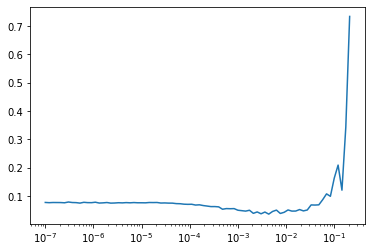

In [ ]:
learn.recorder.plot()

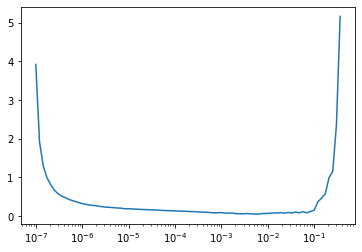

In [ ]:
learn.recorder.plot()

New

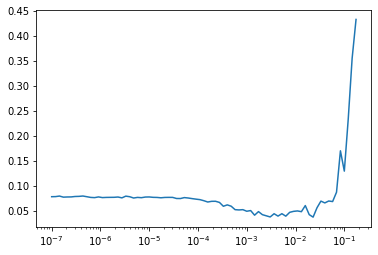

In [ ]:
learn.recorder.plot()

Without major smoothening

Train loss: 0.89689 Valid loss: 0.5151 Valid accuracy: 0.82722


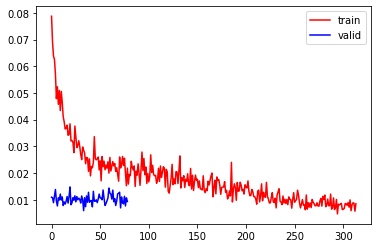

In [ ]:
learn.fit(1)
learn.recorder.plot_losses()

With all smoothening

Train loss: 0.88788 Valid loss: 0.49303 Valid accuracy: 0.83152


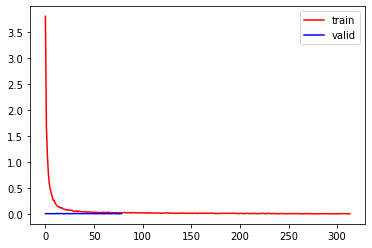

In [ ]:
learn.fit(1)
learn.recorder.plot_losses()

Old

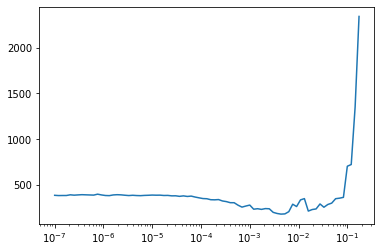

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit(1)

Train loss: 0.8968 Valid loss: 0.48944 Valid accuracy: 0.84025


Using one cycle for each batch seperately

In [ ]:
learn.fit(3)

Train loss: 0.50012 Valid loss: 0.33041 Valid accuracy: 0.89025
Train loss: 0.39129 Valid loss: 0.25303 Valid accuracy: 0.91342
Train loss: 0.32048 Valid loss: 0.22343 Valid accuracy: 0.93013


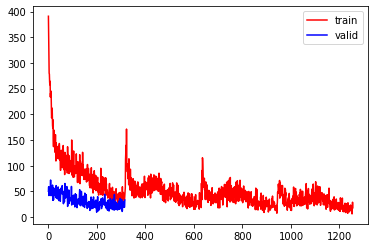

In [ ]:
learn.recorder.plot_losses()

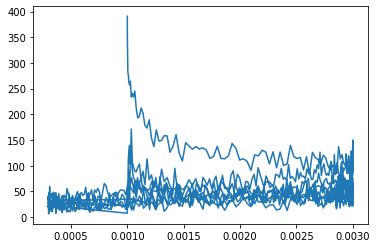

In [ ]:
learn.recorder.plot()

Using one cycle evened out across epochs

In [ ]:
learn.fit(3)

Train loss: 0.88611 Valid loss: 0.61627 Valid accuracy: 0.80785
Train loss: 0.65108 Valid loss: 0.39836 Valid accuracy: 0.87013
Train loss: 0.53685 Valid loss: 0.29967 Valid accuracy: 0.89886


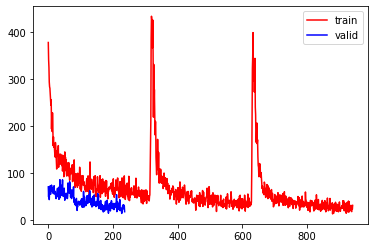

In [ ]:
learn.recorder.plot_losses()

#Training

Version 1.0

In [ ]:
%time learn.fit(6)

Train loss: 0.7352511251855428 Valid loss: 0.473600927127313 Valid accuracy: 0.8425316455696202
Train loss: 0.638502178496173 Valid loss: 0.40047866093458506 Valid accuracy: 0.8660759493670886
Train loss: 0.5557232788663097 Valid loss: 0.35139361717089823 Valid accuracy: 0.8829430379746835
Train loss: 0.49570067816763924 Valid loss: 0.3115689513332482 Valid accuracy: 0.8963797468354431
Train loss: 0.4523248561398935 Valid loss: 0.277942186300073 Valid accuracy: 0.9079535864978903
Train loss: 0.4096460697225026 Valid loss: 0.25185094593567725 Valid accuracy: 0.916745027124774
CPU times: user 12min 53s, sys: 4min 21s, total: 17min 14s
Wall time: 17min 15s


Version 1.1

In [ ]:
%time learn.fit(6)

Train loss: 0.8874763996306873 Valid loss: 0.562932952436614 Valid accuracy: 0.8078481012658227
Train loss: 0.5809208252483397 Valid loss: 0.35013163106473727 Valid accuracy: 0.8867088607594936
Train loss: 0.36256123530962386 Valid loss: 0.23450774540405012 Valid accuracy: 0.9236708860759494
Train loss: 0.2742532883331721 Valid loss: 0.18222618860436532 Valid accuracy: 0.9379746835443038
Train loss: 0.27304153113765817 Valid loss: 0.1583333665662291 Valid accuracy: 0.9524050632911393
Train loss: 0.23884978219588843 Valid loss: 0.11934616508661135 Valid accuracy: 0.959873417721519
CPU times: user 21min 58s, sys: 9min 56s, total: 31min 54s
Wall time: 31min 57s


Version 2.0

In [ ]:
%time learn.fit(6)

Train loss: 0.89577 Valid loss: 0.48908 Valid accuracy: 0.83785
Train loss: 0.50397 Valid loss: 0.33335 Valid accuracy: 0.88759
Train loss: 0.37931 Valid loss: 0.24663 Valid accuracy: 0.91823
Train loss: 0.31447 Valid loss: 0.20239 Valid accuracy: 0.93595
Train loss: 0.29201 Valid loss: 0.19538 Valid accuracy: 0.93266
Train loss: 0.25794 Valid loss: 0.16075 Valid accuracy: 0.9438
CPU times: user 10min 2s, sys: 1min 36s, total: 11min 39s
Wall time: 11min 40s


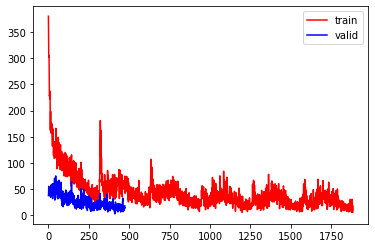

In [ ]:
learn.recorder.plot_losses()

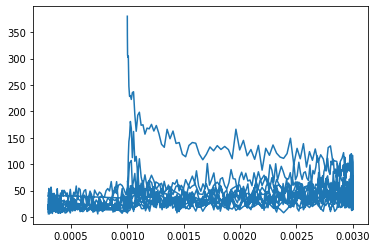

In [ ]:
learn.recorder.plot()

Version 2.1

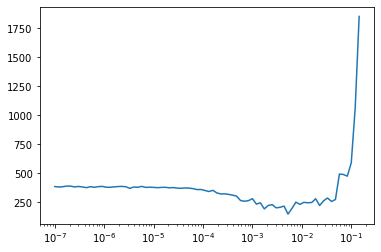

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
%time learn.fit_one_cycle(6, [0.001, 0.003, 0.0003])

Train loss: 0.94307 Valid loss: 0.58348 Valid accuracy: 0.80924
Train loss: 0.7689 Valid loss: 0.40947 Valid accuracy: 0.87228
Train loss: 0.58166 Valid loss: 0.30635 Valid accuracy: 0.90127
Train loss: 0.49122 Valid loss: 0.24418 Valid accuracy: 0.92342
Train loss: 0.42878 Valid loss: 0.19103 Valid accuracy: 0.93747
Train loss: 0.36806 Valid loss: 0.14301 Valid accuracy: 0.95165
CPU times: user 14min 53s, sys: 4min 44s, total: 19min 37s
Wall time: 19min 40s


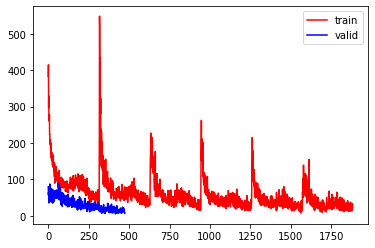

In [ ]:
learn.recorder.plot_losses()

In [ ]:
%time learn.fit_one_cycle(6, [0.001, 0.003, 0.0003])

Train loss: 0.89725 Valid loss: 0.60642 Valid accuracy: 0.80468
Train loss: 0.46517 Valid loss: 0.31612 Valid accuracy: 0.89937
Train loss: 0.29545 Valid loss: 0.41476 Valid accuracy: 0.86165
Train loss: 0.66421 Valid loss: 0.43286 Valid accuracy: 0.86633
Train loss: 0.48307 Valid loss: 0.27069 Valid accuracy: 0.91241
Train loss: 0.19641 Valid loss: 0.1714 Valid accuracy: 0.94924
CPU times: user 15min 21s, sys: 5min 12s, total: 20min 33s
Wall time: 20min 33s


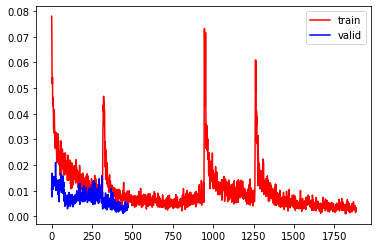

In [ ]:
learn.recorder.plot_losses()